Business Analytics Model On a sales Dataset using the Random Forest Classifier

In [92]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans
import joblib

In [93]:
df = pd.read_csv('sales_dataset.csv')

In [94]:
print(df.isnull().sum()) #identifying missing values

Order ID        0
Amount          0
Profit          0
Quantity        0
Category        0
Sub-Category    0
PaymentMode     0
Order Date      0
CustomerName    0
State           0
City            0
Year-Month      0
dtype: int64


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order ID      1194 non-null   object
 1   Amount        1194 non-null   int64 
 2   Profit        1194 non-null   int64 
 3   Quantity      1194 non-null   int64 
 4   Category      1194 non-null   object
 5   Sub-Category  1194 non-null   object
 6   PaymentMode   1194 non-null   object
 7   Order Date    1194 non-null   object
 8   CustomerName  1194 non-null   object
 9   State         1194 non-null   object
 10  City          1194 non-null   object
 11  Year-Month    1194 non-null   object
dtypes: int64(3), object(9)
memory usage: 112.1+ KB


In [96]:
df. head(5)

,Order ID,Amount,Profit,Quantity,Category,Sub-Category,PaymentMode,Order Date,CustomerName,State,City,Year-Month
0,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,6/27/2023,David Padilla,Florida,Miami,2023-06
1,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,12/27/2024,Connor Morgan,Illinois,Chicago,2024-12
2,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,7/25/2021,Robert Stone,New York,Buffalo,2021-07
3,B-26776,4975,1330,14,Electronics,Printers,UPI,6/27/2023,David Padilla,Florida,Miami,2023-06
4,B-26776,4975,1330,14,Electronics,Printers,UPI,12/27/2024,Connor Morgan,Illinois,Chicago,2024-12


In [97]:
df.Category.unique()

array(['Electronics', 'Office Supplies', 'Furniture'], dtype=object)

In [98]:
df["Sub-Category"].unique()

array(['Electronic Games', 'Printers', 'Pens', 'Laptops', 'Tables',
       'Chairs', 'Markers', 'Sofas', 'Paper', 'Binders', 'Phones',
       'Bookcases'], dtype=object)

In [99]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Step 2: Extract Day, Month, and Year into new columns
# df['Order Day'] = df['Order Date'].dt.day
df['Order Month'] = df['Order Date'].dt.month
df['Order Year'] = df['Order Date'].dt.year

In [100]:
df.drop(columns=['Order Date', 'Year-Month', 'Order ID', 'Order Month', 'CustomerName'], inplace=True)

In [101]:
df['Price'] = df['Amount'] / df['Quantity']

In [102]:
# For demand elasticity we want to see how changes in price affect quantity sales.
# Create log-transformed features:
df['log_Quantity'] = np.log(df['Quantity'])
df['log_Price'] = np.log(df['Price'])
# Note: In a log-log (elasticity) regression, the coefficient on log_Price represents elasticity.

In [103]:
competitor_df = pd.read_csv('SampleSuperstore.csv')

In [104]:
competitor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     9994 non-null   object 
 1   Segment       9994 non-null   object 
 2   Country       9994 non-null   object 
 3   City          9994 non-null   object 
 4   State         9994 non-null   object 
 5   Postal Code   9994 non-null   int64  
 6   Region        9994 non-null   object 
 7   Category      9994 non-null   object 
 8   Sub-Category  9994 non-null   object 
 9   Sales         9994 non-null   float64
 10  Quantity      9994 non-null   int64  
 11  Discount      9994 non-null   float64
 12  Profit        9994 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1015.1+ KB


In [105]:
competitor_df['Price'] = competitor_df['Sales'] / competitor_df['Quantity']

In [106]:
competitor_df.drop(columns=['Postal Code', 'Ship Mode', 'Country', 'City', 'State', 'Region', 'Segment', 'Sales'],inplace=True)

In [107]:
print(competitor_df.isnull().sum()) #identifying missing values

Category        0
Sub-Category    0
Quantity        0
Discount        0
Profit          0
Price           0
dtype: int64


In [108]:
df_join = df.merge(competitor_df, how='left', on=['Category', 'Sub-Category'])

In [109]:
df_join

,Amount,Profit_x,Quantity_x,Category,Sub-Category,PaymentMode,State,City,Order Year,Price_x,log_Quantity,log_Price,Quantity_y,Discount,Profit_y,Price_y
0,9726,1275,5,Electronics,Electronic Games,UPI,Florida,Miami,2023,1945.200000,1.609438,7.573120,NaN,NaN,NaN,NaN
1,9726,1275,5,Electronics,Electronic Games,UPI,Illinois,Chicago,2024,1945.200000,1.609438,7.573120,NaN,NaN,NaN,NaN
2,9726,1275,5,Electronics,Electronic Games,UPI,New York,Buffalo,2021,1945.200000,1.609438,7.573120,NaN,NaN,NaN,NaN
3,4975,1330,14,Electronics,Printers,UPI,Florida,Miami,2023,355.357143,2.639057,5.873123,NaN,NaN,NaN,NaN
4,4975,1330,14,Electronics,Printers,UPI,Illinois,Chicago,2024,355.357143,2.639057,5.873123,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361527,8825,3594,15,Furniture,Tables,Debit Card,New York,New York City,2024,588.333333,2.708050,6.377294,1.0,0.0,22.3548,85.98
361528,2082,642,8,Electronics,Phones,EMI,New York,Rochester,2020,260.250000,2.079442,5.561643,NaN,NaN,NaN,NaN
361529,2082,642,8,Electronics,Phones,EMI,Texas,Austin,2022,260.250000,2.079442,5.561643,NaN,NaN,NaN,NaN
361530,2082,642,8,Electronics,Phones,EMI,New York,Buffalo,2020,260.250000,2.079442,5.561643,NaN,NaN,NaN,NaN


In [110]:
df = df_join.dropna()

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 9 to 361527
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Amount        360806 non-null  int64  
 1   Profit_x      360806 non-null  int64  
 2   Quantity_x    360806 non-null  int64  
 3   Category      360806 non-null  object 
 4   Sub-Category  360806 non-null  object 
 5   PaymentMode   360806 non-null  object 
 6   State         360806 non-null  object 
 7   City          360806 non-null  object 
 8   Order Year    360806 non-null  int32  
 9   Price_x       360806 non-null  float64
 10  log_Quantity  360806 non-null  float64
 11  log_Price     360806 non-null  float64
 12  Quantity_y    360806 non-null  float64
 13  Discount      360806 non-null  float64
 14  Profit_y      360806 non-null  float64
 15  Price_y       360806 non-null  float64
dtypes: float64(7), int32(1), int64(3), object(5)
memory usage: 45.4+ MB


In [112]:
print (df.dtypes)

Amount            int64
Profit_x          int64
Quantity_x        int64
Category         object
Sub-Category     object
PaymentMode      object
State            object
City             object
Order Year        int32
Price_x         float64
log_Quantity    float64
log_Price       float64
Quantity_y      float64
Discount        float64
Profit_y        float64
Price_y         float64
dtype: object


In [113]:
df['Price_Ratio'] = df['Price_x'] / df['Price_y']

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_9076\2225730555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price_Ratio'] = df['Price_x'] / df['Price_y']


In [114]:
df['Price_Ratio']

9          2.652200
10         2.679334
11         1.458710
12         1.934926
13         4.933827
            ...    
361523     1.386892
361524     1.779657
361525    16.552254
361526     4.301185
361527     6.842677
Name: Price_Ratio, Length: 360806, dtype: float64

In [115]:
categorical_cols = ['PaymentMode', 'State', 'City', 'Category', 'Sub-Category', 'Discount', 'Profit_y', 'Profit_x']
# Correct: Select features directly from df]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_9076\682629909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_9076\682629909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_9076\682629909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [116]:
df['Profit_Margin'] = df['Profit_x'] / df['Amount']

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_9076\1406737460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Profit_Margin'] = df['Profit_x'] / df['Amount']


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 9 to 361527
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Amount         360806 non-null  int64  
 1   Profit_x       360806 non-null  int64  
 2   Quantity_x     360806 non-null  int64  
 3   Category       360806 non-null  int64  
 4   Sub-Category   360806 non-null  int64  
 5   PaymentMode    360806 non-null  int64  
 6   State          360806 non-null  int64  
 7   City           360806 non-null  int64  
 8   Order Year     360806 non-null  int32  
 9   Price_x        360806 non-null  float64
 10  log_Quantity   360806 non-null  float64
 11  log_Price      360806 non-null  float64
 12  Quantity_y     360806 non-null  float64
 13  Discount       360806 non-null  int64  
 14  Profit_y       360806 non-null  int64  
 15  Price_y        360806 non-null  float64
 16  Price_Ratio    360806 non-null  float64
 17  Profit_Margin  360806 non-null  fl

In [118]:
# Use selected features that reflect customer behavior (e.g. PaymentMode, State, City, Profit_Margin).
clustering_features = df[['PaymentMode', 'State', 'City', 'Profit_Margin']]
scaler = StandardScaler()
X_cluster = scaler.fit_transform(clustering_features)

# Apply KMeans to group customers into, say, 3 segments.
kmeans = KMeans(n_clusters=4, random_state=42)
df['Customer_Segment'] = kmeans.fit_predict(X_cluster)

C:\Users\Sparkhiee\AppData\Local\Temp\ipykernel_9076\1722680231.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Customer_Segment'] = kmeans.fit_predict(X_cluster)


In [119]:
print(X_cluster.shape)  # Should be (1194, n_features)

(360806, 4)


In [120]:
X = df[['log_Price', 'Price_Ratio', 'Customer_Segment']]
X_clean = X.dropna()

X = sm.add_constant(X)   # Add constant term (intercept)
y = df['log_Quantity']
y_clean = y.loc[X_clean.index]
elasticity_model = sm.OLS(y_clean, X_clean).fit()
print(elasticity_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           log_Quantity   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.787
Method:                 Least Squares   F-statistic:                          4.437e+05
Date:                Mon, 02 Jun 2025   Prob (F-statistic):                        0.00
Time:                        10:31:39   Log-Likelihood:                     -5.1741e+05
No. Observations:              360806   AIC:                                  1.035e+06
Df Residuals:                  360803   BIC:                                  1.035e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [121]:
# STEP 6: BUILDING A MACHINE LEARNING MODEL FOR DEMAND PREDICTION
features_ml = ['Price_x', 'Price_y', 'Price_Ratio', 'Customer_Segment', 
               'PaymentMode', 'State', 'City','Order Year']
X_ml = df[features_ml]
y_ml = df['Quantity_x']

In [122]:
X_ml.info

<bound method DataFrame.info of            Price_x   Price_y  Price_Ratio  Customer_Segment  PaymentMode  \
9       507.937500  191.5155     2.652200                 0            1   
10      507.937500  189.5760     2.679334                 0            1   
11      507.937500  348.2100     1.458710                 0            1   
12      507.937500  262.5100     1.934926                 0            1   
13      507.937500  102.9500     4.933827                 0            1   
...            ...       ...          ...               ...          ...   
361523  588.333333  424.2100     1.386892                 1            2   
361524  588.333333  330.5880     1.779657                 1            2   
361525  588.333333   35.5440    16.552254                 1            2   
361526  588.333333  136.7840     4.301185                 1            2   
361527  588.333333   85.9800     6.842677                 1            2   

        State  City  Order Year  
9           0     8  

In [ ]:
# Splitting the data into features and target
X = df.drop(columns=['Quantity_x'])
y = df['Quantity_x']

In [124]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)

In [125]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 9 to 361527
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Amount            360806 non-null  int64  
 1   Profit_x          360806 non-null  int64  
 2   Quantity_x        360806 non-null  int64  
 3   Category          360806 non-null  int64  
 4   Sub-Category      360806 non-null  int64  
 5   PaymentMode       360806 non-null  int64  
 6   State             360806 non-null  int64  
 7   City              360806 non-null  int64  
 8   Order Year        360806 non-null  int32  
 9   Price_x           360806 non-null  float64
 10  log_Quantity      360806 non-null  float64
 11  log_Price         360806 non-null  float64
 12  Quantity_y        360806 non-null  float64
 13  Discount          360806 non-null  int64  
 14  Profit_y          360806 non-null  int64  
 15  Price_y           360806 non-null  float64
 16  Price_Ratio       360806 

In [127]:
#from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Building and training the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [128]:
df.head()

,Amount,Profit_x,Quantity_x,Category,Sub-Category,PaymentMode,State,City,Order Year,Price_x,log_Quantity,log_Price,Quantity_y,Discount,Profit_y,Price_y,Price_Ratio,Profit_Margin,Customer_Segment
9,8127,276,16,0,4,1,0,8,2022,507.9375,2.772589,6.230358,5.0,7,48,191.5155,2.652200,0.033961,0
10,8127,276,16,0,4,1,0,8,2022,507.9375,2.772589,6.230358,9.0,3,2594,189.5760,2.679334,0.033961,0
11,8127,276,16,0,4,1,0,8,2022,507.9375,2.772589,6.230358,3.0,0,2799,348.2100,1.458710,0.033961,0
12,8127,276,16,0,4,1,0,8,2022,507.9375,2.772589,6.230358,3.0,0,2745,262.5100,1.934926,0.033961,0
13,8127,276,16,0,4,1,0,8,2022,507.9375,2.772589,6.230358,6.0,8,46,102.9500,4.933827,0.033961,0


In [129]:
df.isnull().sum()

Amount              0
Profit_x            0
Quantity_x          0
Category            0
Sub-Category        0
PaymentMode         0
State               0
City                0
Order Year          0
Price_x             0
log_Quantity        0
log_Price           0
Quantity_y          0
Discount            0
Profit_y            0
Price_y             0
Price_Ratio         0
Profit_Margin       0
Customer_Segment    0
dtype: int64

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360806 entries, 9 to 361527
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Amount            360806 non-null  int64  
 1   Profit_x          360806 non-null  int64  
 2   Quantity_x        360806 non-null  int64  
 3   Category          360806 non-null  int64  
 4   Sub-Category      360806 non-null  int64  
 5   PaymentMode       360806 non-null  int64  
 6   State             360806 non-null  int64  
 7   City              360806 non-null  int64  
 8   Order Year        360806 non-null  int32  
 9   Price_x           360806 non-null  float64
 10  log_Quantity      360806 non-null  float64
 11  log_Price         360806 non-null  float64
 12  Quantity_y        360806 non-null  float64
 13  Discount          360806 non-null  int64  
 14  Profit_y          360806 non-null  int64  
 15  Price_y           360806 non-null  float64
 16  Price_Ratio       360806 

In [131]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Amount,360806.0,5168.516527,2819.725052,514.000000,2939.000000,4985.000000,7620.000000,9989.000000
Profit_x,360806.0,142.762631,86.535986,0.000000,65.000000,148.000000,215.000000,296.000000
Quantity_x,360806.0,9.928233,5.807659,1.000000,5.000000,9.000000,15.000000,20.000000
Category,360806.0,0.694592,0.460581,0.000000,0.000000,1.000000,1.000000,1.000000
Sub-Category,360806.0,1.955616,1.441800,0.000000,0.000000,3.000000,3.000000,4.000000
PaymentMode,360806.0,2.077657,1.428717,0.000000,1.000000,2.000000,3.000000,4.000000
State,360806.0,2.208250,1.653330,0.000000,1.000000,2.000000,4.000000,5.000000
City,360806.0,9.075309,5.279447,0.000000,4.000000,9.000000,14.000000,17.000000
Order Year,360806.0,2022.322508,1.461892,2020.000000,2021.000000,2022.000000,2024.000000,2025.000000
Price_x,360806.0,995.751442,1445.576777,26.550000,295.875000,532.500000,1070.375000,9894.000000


In [132]:
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Print the correlation matrix
print("Correlation Matrix (Raw):\n", correlation_matrix)



Correlation Matrix (Raw):
                     Amount  Profit_x  Quantity_x  Category  Sub-Category  \
Amount            1.000000  0.728423    0.010023  0.020017     -0.044436   
Profit_x          0.728423  1.000000    0.005145  0.009910     -0.018482   
Quantity_x        0.010023  0.005145    1.000000 -0.099833      0.001253   
Category          0.020017  0.009910   -0.099833  1.000000     -0.261533   
Sub-Category     -0.044436 -0.018482    0.001253 -0.261533      1.000000   
PaymentMode       0.020162 -0.001665    0.010488  0.002006      0.057871   
State            -0.021497 -0.057713   -0.093251 -0.057475     -0.036726   
City              0.112712  0.087432    0.032477  0.018398     -0.034309   
Order Year       -0.022995 -0.046184   -0.072966  0.043333      0.002554   
Price_x           0.360808  0.204876   -0.561920  0.064303     -0.079179   
log_Quantity      0.020144  0.038804    0.927282 -0.087382      0.016055   
log_Price         0.613433  0.440340   -0.703200  0.081651   

In [133]:
y_pred[:10]

array([4., 2., 6., 4., 6., 9., 4., 8., 1., 9.])

In [134]:
y_test[:10].values

array([4, 2, 6, 4, 6, 9, 4, 8, 1, 9])

In [135]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error


In [136]:
print("--- Model Evaluation ---")

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
print(f"\nR-squared (R2 Score): {r2:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error (MSE): {mse:.2f}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"\nMean Absolute Error (MAE): {mae:.2f}")

--- Model Evaluation ---

R-squared (R2 Score): 1.0000

Mean Squared Error (MSE): 0.00

Root Mean Squared Error (RMSE): 0.01

Mean Absolute Error (MAE): 0.00


### Predicted vs. Actual Values Scatter Plot

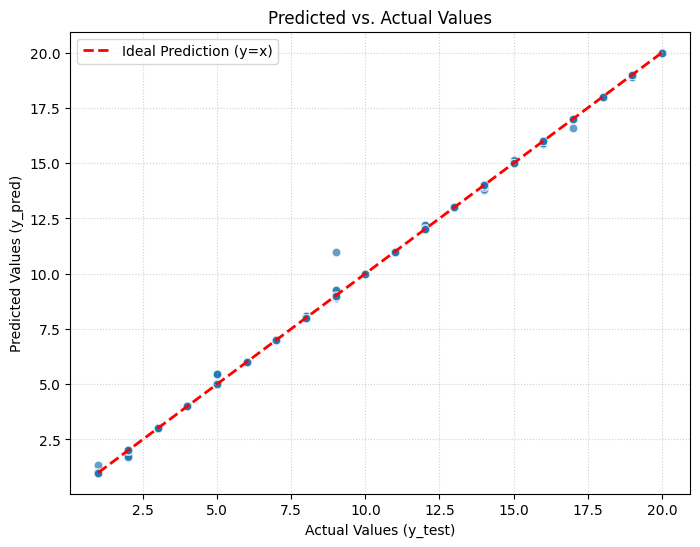

In [137]:
residuals = y_test - y_pred


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal Prediction (y=x)')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()


In [138]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'encoders.pkl')
joblib.dump(elasticity_model, 'elasticity_model.pkl')


['elasticity_model.pkl']

relationship between log(Price) and log(Quantity) colored by customer segment.

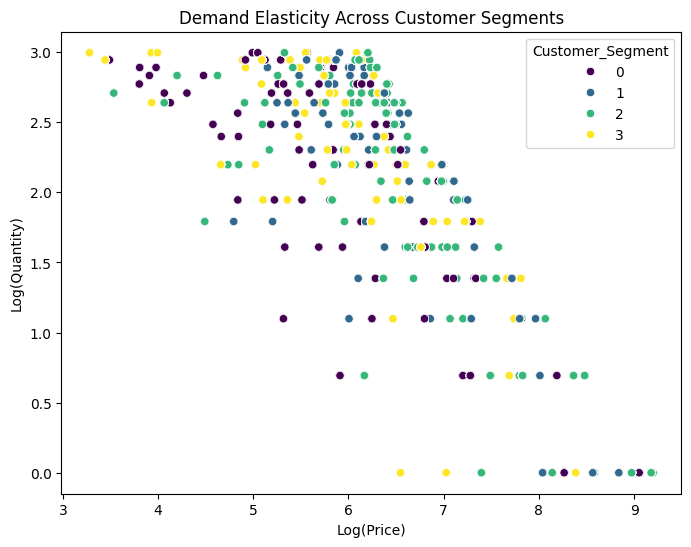

In [139]:
# Plot the relationship between log(Price) and log(Quantity) colored by customer segment.
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='log_Price', y='log_Quantity', hue='Customer_Segment', palette='viridis')
plt.title("Demand Elasticity Across Customer Segments")
plt.xlabel("Log(Price)")
plt.ylabel("Log(Quantity)")
plt.show()